In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import pandas as pd
from functools import reduce

In [2]:
%run '../src/cancer_utilies.ipynb'

notebook run


In [3]:
# initialize sparksession
spark = SparkSession.builder.appName('app').getOrCreate()
# initialize list of lists

data = [['Rand1', 'C34,C18,C19', '2021-01-01'], 
        ['Rand1', 'C34,C18,C19', '2020-12-29'],
        ['Rand3', 'C50', '2021-07-10'], 
        ['Rand3', 'C50,C21,C50', '2021-04-01'], 
        ['Rand3', 'J12, C20', '2021-06-01'],
        ['Rand3', 'J12, C20', '2021-06-02'] ]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['dummy_name', 'dummy_condition','dummy_admis'])

21/10/26 12:34:12 WARN Utils: Your hostname, Zachs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
21/10/26 12:34:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/26 12:34:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark_df = spark.createDataFrame(df)
cancer_chapter_instance =  CreateCancerHighLevel_ML(spark_df)
cancer_chapter_instance.show()

+----------+---------------+-----------+
|dummy_name|dummy_condition|dummy_admis|
+----------+---------------+-----------+
|     Rand1|    C34,C18,C19| 2021-01-01|
|     Rand1|    C34,C18,C19| 2020-12-29|
|     Rand3|            C50| 2021-07-10|
|     Rand3|    C50,C21,C50| 2021-04-01|
|     Rand3|       J12, C20| 2021-06-01|
|     Rand3|       J12, C20| 2021-06-02|
+----------+---------------+-----------+



In [5]:
diag_col = 'dummy_condition'
C18_C21_df = cancer_chapter_instance .chapters_C18_C21_Colorectal(diag_col)
C34_df = cancer_chapter_instance.chapters_C34_Lung(diag_col) 

In [6]:
def unionAll_custom(dfs, fill_by=0):
    
    clmns = {clm.name.lower(): (clm.dataType, clm.name) for df in dfs for clm in df.schema.fields}

    for i, df in enumerate (dfs):
        df_clmns = [clm. lower() for clm in df.columns]
        for clm, (dataType, name) in clmns.items():
            if clm not in df_clmns:
                # Add the missing column
                dfs[i] = dfs[i].withColumn(name, F.lit(fill_by).cast(dataType))
    return reduce(DataFrame.unionByName, dfs)

In [7]:
cancer_union = unionAll_custom([C18_C21_df,C34_df])

In [8]:
cancer_union.show()

+----------+---------------+-----------+----------+----+
|dummy_name|dummy_condition|dummy_admis|Colorectal|Lung|
+----------+---------------+-----------+----------+----+
|     Rand1|    C34,C18,C19| 2021-01-01|         1|   0|
|     Rand1|    C34,C18,C19| 2020-12-29|         1|   0|
|     Rand3|            C50| 2021-07-10|      null|   0|
|     Rand3|    C50,C21,C50| 2021-04-01|         1|   0|
|     Rand3|       J12, C20| 2021-06-01|         1|   0|
|     Rand3|       J12, C20| 2021-06-02|         1|   0|
|     Rand1|    C34,C18,C19| 2021-01-01|         0|   1|
|     Rand1|    C34,C18,C19| 2020-12-29|         0|   1|
|     Rand3|            C50| 2021-07-10|         0|null|
|     Rand3|    C50,C21,C50| 2021-04-01|         0|null|
|     Rand3|       J12, C20| 2021-06-01|         0|null|
|     Rand3|       J12, C20| 2021-06-02|         0|null|
+----------+---------------+-----------+----------+----+



In [9]:
(cancer_union.groupBy().sum()).show()

+---------------+---------+
|sum(Colorectal)|sum(Lung)|
+---------------+---------+
|              5|        2|
+---------------+---------+



In [10]:
cancer_union_fill = cancer_union.na.fill(0)

In [11]:
cancer_union_fill.show()

+----------+---------------+-----------+----------+----+
|dummy_name|dummy_condition|dummy_admis|Colorectal|Lung|
+----------+---------------+-----------+----------+----+
|     Rand1|    C34,C18,C19| 2021-01-01|         1|   0|
|     Rand1|    C34,C18,C19| 2020-12-29|         1|   0|
|     Rand3|            C50| 2021-07-10|         0|   0|
|     Rand3|    C50,C21,C50| 2021-04-01|         1|   0|
|     Rand3|       J12, C20| 2021-06-01|         1|   0|
|     Rand3|       J12, C20| 2021-06-02|         1|   0|
|     Rand1|    C34,C18,C19| 2021-01-01|         0|   1|
|     Rand1|    C34,C18,C19| 2020-12-29|         0|   1|
|     Rand3|            C50| 2021-07-10|         0|   0|
|     Rand3|    C50,C21,C50| 2021-04-01|         0|   0|
|     Rand3|       J12, C20| 2021-06-01|         0|   0|
|     Rand3|       J12, C20| 2021-06-02|         0|   0|
+----------+---------------+-----------+----------+----+



In [12]:
cancer_union_fill_dedup = cancer_union_fill.dropDuplicates()
cancer_union_fill_dedup.show()

+----------+---------------+-----------+----------+----+
|dummy_name|dummy_condition|dummy_admis|Colorectal|Lung|
+----------+---------------+-----------+----------+----+
|     Rand3|       J12, C20| 2021-06-02|         1|   0|
|     Rand3|       J12, C20| 2021-06-01|         0|   0|
|     Rand1|    C34,C18,C19| 2021-01-01|         1|   0|
|     Rand3|       J12, C20| 2021-06-01|         1|   0|
|     Rand3|            C50| 2021-07-10|         0|   0|
|     Rand1|    C34,C18,C19| 2020-12-29|         1|   0|
|     Rand3|    C50,C21,C50| 2021-04-01|         0|   0|
|     Rand1|    C34,C18,C19| 2020-12-29|         0|   1|
|     Rand3|       J12, C20| 2021-06-02|         0|   0|
|     Rand3|    C50,C21,C50| 2021-04-01|         1|   0|
|     Rand1|    C34,C18,C19| 2021-01-01|         0|   1|
+----------+---------------+-----------+----------+----+



In [13]:
cancer_union_fill_dedup.groupBy().sum().collect()

[Row(sum(Colorectal)=5, sum(Lung)=2)]

In [14]:
agg_can_phenotypes = ['Lung','Colorectal']

In [15]:
agg_can_dfs = []

for cancer_type in agg_can_phenotypes:
    grouped_data_cancers = cancer_union_fill_dedup.groupBy(["dummy_admis", cancer_type]).agg({f'{cancer_type}':'sum'})
    grouped_data_cancers = grouped_data_cancers.drop(cancer_type) 
    grouped_data_cancers = grouped_data_cancers.withColumn('CANCER_CATEGORY', F.lit(f'{cancer_type}')) 
    ordered_df = grouped_data_cancers.orderBy(['dummy_admis'])
    agg_can_dfs.append(ordered_df)

In [16]:
dfs_colnames_dict = dict(zip(agg_can_dfs, agg_can_phenotypes))

In [17]:
new_dfs =[]
    
for df, column_name in dfs_colnames_dict.items():
    df = df.withColumnRenamed(f'sum({column_name})', 'count')
    new_dfs.append(df)

In [18]:
reduced_dfs = reduce(DataFrame.union, new_dfs)

In [19]:
(reduced_dfs.groupBy ('CANCER_CATEGORY').sum()).show()

+---------------+----------+
|CANCER_CATEGORY|sum(count)|
+---------------+----------+
|     Colorectal|         5|
|           Lung|         2|
+---------------+----------+



In [24]:
test = (reduced_dfs). toPandas()
test.head()

,dummy_admis,count,CANCER_CATEGORY
0,2020-12-29,0,Lung
1,2020-12-29,1,Lung
2,2021-01-01,0,Lung
3,2021-01-01,1,Lung
4,2021-04-01,0,Lung


In [25]:
import pandas as pd
test['dummy_admis'] = pd.to_datetime(test['dummy_admis'], format='%Y-%m')
weekly_freq = test.groupby('CANCER_CATEGORY').resample('W',on='dummy_admis').sum()
weekly_freq.reset_index(inplace = True)
# weekly_freq.head()

In [26]:
weekly_freq['moving'] = weekly_freq.groupby('CANCER_CATEGORY').rolling(7)['count'].mean().reset_index(drop = True) 
weekly_freq.head()
#weekly_freq.set_index('dummy_admis', inplace=True)

,CANCER_CATEGORY,dummy_admis,count,moving
0,Colorectal,2021-01-03,2,NaN
1,Colorectal,2021-01-10,0,NaN
2,Colorectal,2021-01-17,0,NaN
3,Colorectal,2021-01-24,0,NaN
4,Colorectal,2021-01-31,0,NaN


<AxesSubplot:xlabel='dummy_admis', ylabel='moving'>

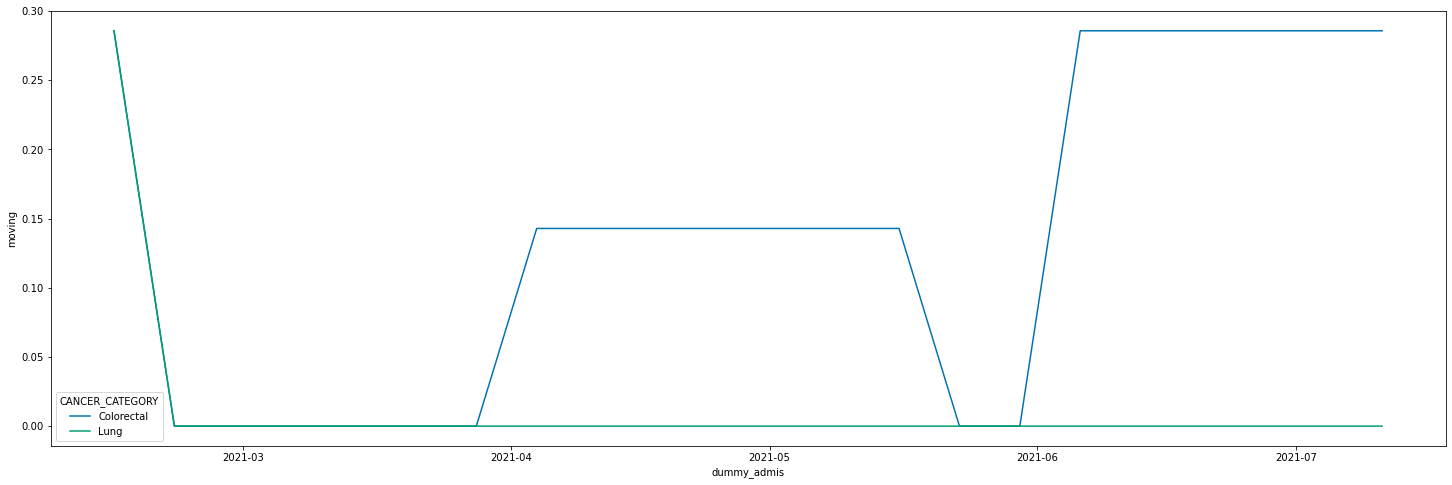

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (25,8) 
plt.style.use('seaborn-colorblind')
sns.lineplot(x=weekly_freq.dummy_admis, y='moving', hue='CANCER_CATEGORY' ,data=weekly_freq)